# Вдудь

Анализируем комментарии с ютуба

<img src="vdud_img.png">

In [119]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import re
from string import punctuation
import gensim
from gensim import corpora, models

import multiprocessing
import emoji
import warnings
from collections import defaultdict
import pickle
from time import time
from tqdm.notebook import tqdm

In [120]:
text_coms = pd.read_pickle('all_comms.pickle')

In [121]:
df_coms = pd.read_csv('vdud_coms.csv', index_col = False)

text_coms = pd.read_pickle('all_comms.pickle')
df_coms.comms_text = [text for text in text_coms]
df_coms.drop(['Unnamed: 0'], axis=1, inplace=True)

print(df_coms.shape)

(118, 12)


In [124]:
df_coms.iloc[61].guest

'Ресторатор'

Таблица с информацией обо всех выпусках, нам интересен крайний столбец - comms_text. В этом столбце содержится список всех комментариев к выпуску (без реплайев)

In [32]:
df_coms.head()

full_title          guest  length  \
0  Максим Фадеев - о конфликте с Эрнстом и русско...  Максим Фадеев      52   
1         Невзоров - о Фараоне и ориентации Милонова       Невзоров      85   
2                                      Колокольников  Колокольников      72   
3           Собчак - о Навальном, крестном и выборах         Собчак      96   
4               Щербаков - спецназ, панк-рок, любовь       Щербаков      99   

      views     likes  dislikes        date  comments_num  likes/dislikes  \
0   8621967  167000.0   11000.0  2017-05-16         30245       15.181818   
1  14349677  326000.0   26000.0  2018-01-30         47203       12.538462   
2   3884574   79000.0    9200.0  2018-05-22         11053        8.586957   
3  14875828  251000.0   67000.0  2017-10-24         52065        3.746269   
4  21323332  789000.0   45000.0  2020-01-28        125871       17.533333   

   views/likes  views/comments_num  \
0    51.628545          285.070822   
1    44.017414          303.999259   
2    49.171823          351.449742   
3    59.266247          285.716470   
4    27.025769          169.406233   

                                          comms_text  
0  [Кое-что из внутренностей:\n\n0:37 Что Фадееву...  
1  [00:38 Что и кому Невзоров преподает в итальян...  
2  [0:23 Сниматься в настоящем крематории в гробу...  
3  [Кое-что из внутренностей:\n\n00:24 Еще 4 меся...  
4  [Что происходит?\n\n1:02 Щербаков стал суперзв...

## Анализируем один выпуск

- убрать слишком короткие комменты(<5)
- удалить комменты, содержащие конкурс (учесть, то что в нескольких первых выпусках хэштег не ставили)
- перевести слова в нормальную форму, учесть неправильное написание некоторых слов(в особенности фамилий)
- токенизировать так, чтобы удалить цифры, латиницу, смайлы

word_tokenize из nltk разделяет по пробелам и знакам препинания

In [33]:
class nlp_model:
    def __init__(self, guest):
        self.guest = guest
        self.coms = df_coms[df_coms.guest==guest].comms_text.values[0]
        self.clean_coms = self.cleanComsTokens()
        self.unite_tokens = self.uniteTokens()
        self.coms_tokens = self.comsTokens()
        
    def cleanComsTokens(self):
        # Убираем первый коммент с таймкодами
        self.coms = self.coms[1:]
        new_coms = []
        # Работаем с каждым комментом
        for i,com in enumerate(self.coms):
            # Убираем комменты короче 5 символов
            if len(com)<5:
                self.coms.remove(com)   
            # Убираем комменты со словом конкурс
            if com.lower().find('конкурс') != -1:
                self.coms.remove(com)
            # Декодируем эмоджи
            com = emoji.demojize(com)
            # Избавляемся от латиницы
            com = re.sub('[A-Za-z]', '', com)
            # Избавляемся от цифр
            com = re.sub('[0-9]', '', com)
            # Избавляемся от пунктуации
            com = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»]', '', com)
            new_coms.append(com)
        # Переводим в Lowercase и токенизируем
        clean_coms = [word_tokenize(com.lower()) for com in new_coms]

        # Работаем с каждым словом
        morph = pymorphy2.MorphAnalyzer()
        bow = []
        for com in clean_coms:
            new_com = []
            for word in com:
                word_normal = morph.parse(word)[0].normal_form
                if len(word_normal)>2 and word_normal not in stopwords.words('russian'):
                    new_com.append(word_normal)
            if new_com != '':
                bow.append(new_com)
        return bow
    
    # На вход список списков слов
    # На выход список слов
    def uniteTokens(self):
        new_coms=[]
        for com in self.clean_coms:
            for word in com:
                new_coms.append(word)
        return new_coms
    def comsTokens(self):
        return [' '.join(com) for com in self.clean_coms]

    # На вход список слов
    # На выход кортеж из объекта вектора и самого вектора
    def countVectorizer(self, bigram=False):
        if (bigram):
            vectorizer = CountVectorizer(ngram_range=(1,2),
                                                min_df = 3,
                                                max_df = .3,
                                                stop_words = stopwords.words('russian'))
            X = vectorizer.fit_transform(self.coms_tokens)
            print(X.shape)
            return (vectorizer, X)
        else:
            vectorizer = CountVectorizer(stop_words = stopwords.words('russian'),
                                min_df = 3,
                                max_df = .3)
            X = vectorizer.fit_transform(self.coms_tokens)
            print(X.shape)
            return (vectorizer, X)
    
    def tfidfVectorizer(self, bigram=False):
        if (bigram):
            vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                     min_df = 3,
                                     max_df = .3,
                                     stop_words = stopwords.words('russian'))
            X = vectorizer.fit_transform(self.coms_tokens)
            print(X.shape)
            return (vectorizer, X)
        else:
            vectorizer = TfidfVectorizer(stop_words = stopwords.words('russian'),
                                min_df = 3)
            X = vectorizer.fit_transform(self.coms_tokens)
            print(X.shape)
            return (vectorizer, X)
    
    # На вход получаем количество тем и кортеж - объект векторизатора и сам вектор комментов
    # На выход список тем
    def NMF_model(self, vectorizer_vector, n_components=3, n_words = 10):
        nmf = NMF(n_components=n_components, random_state=1,
                  alpha=.1, 
                  l1_ratio=.5).fit(vectorizer_vector[1])

        vectorizer_feature_names = vectorizer_vector[0].get_feature_names()
        print("\nTopics in NMF model:")
        self.printTopWords(nmf, vectorizer_feature_names, n_words)

    def LDA_model(self,vectorizer_vector, n_components=3, n_words = 10):
        lda = LatentDirichletAllocation(n_components=n_components, 
                                        max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(vectorizer_vector[1])

        vectorizer_feature_names = vectorizer_vector[0].get_feature_names()
        print("\nTopics in LDA model:")
        self.printTopWords(lda, vectorizer_feature_names, n_words)

    # Вывести топ слова для sklearn реализации    
    def printTopWords(seld, model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([feature_names[i]
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
        print()
        
    # На вход имя гостя, количество тем и количество слов
    # На выход ЛДА модель с каунт вектором и НМФ модель с тифайдиф  вектором с биграммами
    # Плюс нарисовать частотную карту слов
    def topics(self, n_topics=3, n_words=15):
        print(self.guest)
        print('=========================================================')
        print('LDA one word countvectorizer')
        self.LDA_model(self.countVectorizer())

        print('NMF bigram tfidf')
        self.NMF_model(self.tfidfVectorizer())
        self.drawWords()
        
    # На вход список документов
    # НА выход модель
    def cbow(self, min_count=3):
        model_all_cbow = models.Word2Vec(sentences = self.clean_coms, window=3,
                                         min_count=min_count, sg=0)
        return model_all_cbow

    # Нарисовать облако слов
    def drawWords(self, max_words=50):
        plt.figure(figsize=(15,10))
        WC = WordCloud(width=1000, height=1000, max_words=max_words, min_font_size=5,
                       background_color="white",
                       stopwords = stopwords.words('russian'))
        words_plot = WC.generate(" ".join(self.unite_tokens))
        plt.imshow(words_plot, interpolation='bilinear')
        plt.axis("off")
        plt.show;

Класс npl_model создан для анализа комментариев с одного выпуска.
Разберем, что делает этот класс на примере интервью Ресторатора.

In [5]:
df_coms[df_coms.guest=='Ресторатор']

full_title       guest  length    views  \
61  Ресторатор - об Оксимироне, цензуре и бабле  Ресторатор      48  7798027   

       likes  dislikes        date  comments_num  likes/dislikes  views/likes  \
61  178000.0   11000.0  2017-03-07          7174       16.181818     43.80914   

    views/comments_num                                         comms_text  
61         1086.984527  [Кое-что из внутренностей: \n\n03:25 На какой ...

У выпуска 7174 комментария, но это вместе в реплаями. Мы будем анализировать без реплайев.

In [6]:
len(df_coms[df_coms.guest=='Ресторатор'].comms_text.values[0])

5755

Получили 5755 комментариев. Посмотрим на несколько.

In [7]:
df_coms[df_coms.guest=='Ресторатор'].comms_text.values[0][3485:3490]

['Ресторатор воплощает собой успешного алкоголика,\nОтличает от нолика только толика трудоголика, а\nПлюсов интервью для лысого сосчитать несложно и школьнику -\nОно люто быстро само прославит всем карьеру веселенькой.',
 'ВОРОН БАФФИТ БЛЯАТЬ. ВСЁ ДОСВИДОС',
 'Он настолько лысый, что отражает реп лучше луны',
 'Это хороший был выпуск, и даже мне он понравился сука.\nНедавно смотрел хуякс где Рестор не то, что на бэхе он там вообще блядь без зуба.\nА щас известный стал стволы покупает опасный как ртуть\nЗа этот выпуск спасибо каналу ВДУДЬ)',
 'Ресторатор грамотный и адекватный парень!. а то что у тебя переживание есть и ты выпеваешь перед записью то это норм :D и это первый раз когда такую передачу я досмотрел до конца!']

In [8]:
%%time
restor = nlp_model('Ресторатор')

Wall time: 49.4 s


Аттрибут guest выдает имя гостя

In [9]:
restor.guest

'Ресторатор'

Аттрибут coms выдает список комментариев без: 
- первого коммента (с таймкодами)
- комментов, которые короче 5 символов
- комментов, содержащих слово конкурс (начало функции cleanComsTokens).

In [10]:
print('Количество комментов: ', len(restor.coms))
restor.coms[3485:3490]

Количество комментов:  5681


['Вообще далек от рэп культуры. Но смотреть очень прикольно. Как слушать радио спорт. Них не понятно о чем речь но по руссски. И это клево. \nРесторатор очень адекватный чел. Думаю у него успех может быть в Любой сфере. \nЮрий спасибо вам за проект. Хоть по политике с вами и не согласен',
 'самий нудний випуск',
 'Ресторатор, он будто бы настолько\xa0остроумен, что шутит так будто в жопе застрял вибратор!',
 'Ресторатор очень толковый ! Очень грамотные вещи говорит ! Красавчик ! Удачи тебе в дальнейших проектах !!',
 'Ты так тоскуешь по Оксане?\nГод вы не виделись уже!\nПрокатишь ты его на бехе,\nНе скажешь ты это жене.\n\nИ подготовив его к батлу,\nРаботав лысой головой.\nОтдашь его Американцу!\nСперва на ночь, потом на бой.\n\nНе проиграет эту схватку,\nВедь подготовил его ты.\nТы говоришь о нем так много,\nБуд то ночами вы одни.\n\nПусть не возьмет тебя Хованский,\nВедь ты не 45кг, \nТы не печалься, Ресторатор.\nВсе же трусливый ты в душе.\n\nP.S. все сказанное выше лишь ради рифмы 

Аттрибут clean_coms выдает результат функции cleanComsTokens: 
- Удаляем цифры, латиницу, эмоджи и знаки препинания
- Переводим весь оставшийся текст в нижний регистр
- Токенизируем каждый коммент
-  Приводим слова к нормальной форме

In [11]:
print('Количество комментов: ', len(restor.clean_coms))
restor.clean_coms[3490]

Количество комментов:  5682


['рестор', 'четыре', 'год', 'назад', 'айфон', 'продавать']

Получили на даже на один коммент больше. В итоге у нас список списков слов, то есть вместо коммента в списке имеем список отфильтрованных слов в нормальной форме.

Аттрибут unite_tokens просто выдает список всех слов (мешок слов = bag of words). Здесь мы не учитываем каждый комментарий отдельно, а только и совокупность всех использованных слов.

In [12]:
print('Количество слов: ', len(restor.unite_tokens))
print('Количество уникальных слов: ', len(set(restor.unite_tokens)))
restor.unite_tokens[3485:3490]

Количество слов:  51286
Количество уникальных слов:  11581


['шок', 'муж', 'служить', 'самый', 'долбануть']

Аттрибут coms_tokens - список всех комментов, составленных из слов в нормальной форме.

In [13]:
print('Количество комментариев: ', len(restor.coms_tokens))
restor.coms_tokens[3485:3490]

Количество комментариев:  5682


['вообще далёкий рэп культура смотреть очень прикольно слушать радио спорт понятно речь руссски это клёво ресторатор очень адекватный чел думать успех мочь любой сфера юрий спасибо проект политика согласный',
 'самия нудний випуск',
 'ресторатор настолько остроумный шутить жопа застрять вибратор',
 'ресторатор очень толковый очень грамотный вещь говорить красавчик удача дальнейший проект',
 'тосковать оксана год видеться прокатить бех сказать это жена подготовить батл работать лысый голова отдать американец сперва ночь бой проиграть схватка подготовить говорить немой буд ночь пусть взять хованский печалиться ресторатор всё трусливый душа всё сказать выше лишь ради рифма улыбка хотеть оскорблять оксить хован ресторатор достойный уважение расписывать скок угодный мочь']

Переводим список слов в численное представление с помощью countVectorizer из sklearn. 
Убираем русские стоп-слова, используем только слова которые встретились чаще трех раз и в менее, чем в 30% комментариев.

Имеем в качестве строк 5682 коммента, 2718 уникальных слов в качестве столбцов(слова, которые встречаются большее 2 раз во всем корпусе)

In [14]:
restor.countVectorizer()

(5682, 2718)


(CountVectorizer(max_df=0.3, min_df=3,
                 stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                             'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                             'по', 'только', 'ее', 'мне', ...]),
 <5682x2718 sparse matrix of type '<class 'numpy.int64'>'
 	with 38166 stored elements in Compressed Sparse Row format>)

In [15]:
restor.countVectorizer()[1].toarray()

(5682, 2718)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Словарь всех слов, номеров столбцов

In [16]:
restor.countVectorizer()[0].vocabulary_

(5682, 2718)


{'уорен': 2482,
 'баффет': 91,
 'оксимирон': 1393,
 'позвать': 1651,
 'интервью': 814,
 'юра': 2698,
 'дудь': 581,
 'инвестор': 805,
 'бизнесмен': 112,
 'заесть': 682,
 'шуметь': 2681,
 'пора': 1718,
 'начинать': 1263,
 'музыка': 1184,
 'вместо': 273,
 'некогда': 1280,
 'африканский': 42,
 'юрий': 2700,
 'выбрать': 345,
 'пиво': 1547,
 'будущее': 183,
 'всё': 334,
 'честно': 2623,
 'рэп': 2029,
 'это': 2696,
 'рокнролл': 2009,
 'дерзость': 503,
 'молодость': 1163,
 'блядь': 136,
 'хуйня': 2587,
 'репа': 1967,
 'продажный': 1836,
 'панк': 1491,
 'остаться': 1426,
 'просто': 1867,
 'ссыкун': 2247,
 'бояться': 161,
 'скандал': 2109,
 'итог': 838,
 'тело': 2349,
 'тупо': 2417,
 'алкогольный': 21,
 'зависимость': 665,
 'хотеть': 2577,
 'твой': 2342,
 'очень': 1477,
 'яркий': 2714,
 'область': 1355,
 'год': 414,
 'саша': 2045,
 'энди': 2693,
 'невский': 1270,
 'понять': 1706,
 'вопрос': 304,
 'страх': 2285,
 'панический': 1490,
 'атака': 40,
 'мысль': 1188,
 'действие': 490,
 'социофобия': 2

С помощью моделей LDA и NMF выделяем три темы выпуска, плюс рисуем облако наиболее используемых слов

Ресторатор
LDA one word countvectorizer
(5682, 2718)

Topics in LDA model:
Topic #0: это ресторатор всё батлы человек хороший весь свой юрий сказать
Topic #1: ресторатор лысый твой очень крутой панч реклама интересный смотреть выпуск
Topic #2: блядь пошуметь саня дудь рестор респект версус лайк пиво топ

NMF bigram tfidf
(5682, 2718)

Topics in NMF model:
Topic #0: ресторатор лысый хороший человек всё респект панч батлы засос крутой
Topic #1: это блядь всё вообще знать пошуметь батлы человек весь хороший
Topic #2: дудь юрий дуть интервью хороший заебал позвать вставка интересно интересный



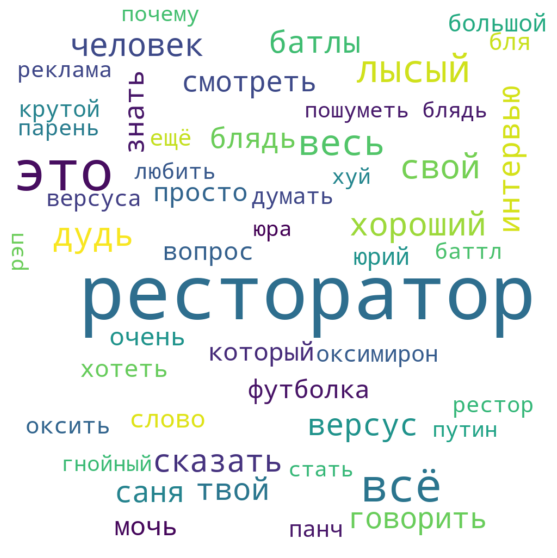

In [17]:
restor.topics()

Можно выделить две темы:
- Ресторатор крутой
- Хорошее интервью

С помощью функции cbow() применяем модель word2vec (реализация библиотеки gensim).

In [18]:
restor_cbow = restor.cbow().wv

Посмотрим схожие слова.

In [19]:
restor_cbow.most_similar(positive=['оксимирон'])

[('свой', 0.9998695254325867),
 ('смотреть', 0.9998566508293152),
 ('весь', 0.9998557567596436),
 ('версус', 0.9998501539230347),
 ('реклама', 0.9998448491096497),
 ('батлы', 0.9998430013656616),
 ('новый', 0.9998425245285034),
 ('это', 0.9998416304588318),
 ('парень', 0.9998390674591064),
 ('ресторатор', 0.9998388290405273)]

In [20]:
restor_cbow.most_similar(positive=['дудь'])

[('батлы', 0.999874472618103),
 ('версус', 0.9998739957809448),
 ('саня', 0.9998733401298523),
 ('ресторатор', 0.9998732209205627),
 ('ещё', 0.9998722076416016),
 ('всё', 0.9998703598976135),
 ('пиво', 0.9998665452003479),
 ('это', 0.9998651742935181),
 ('человек', 0.999862551689148),
 ('мочь', 0.9998620748519897)]

Не так много смысла, скорее всего потому что слишком мало слов

In [21]:
len(restor_cbow.vocab)

2780

Посмотрим на выпуски с большм количеством комментов.

In [22]:
df_coms.sort_values('comments_num', ascending=False).head(10)

full_title         guest  length  \
28             Навальные – интервью после отравления     Навальные     140   
68                     Колыма - родина нашего страха        Колыма     137   
16  Давидыч - огромное интервью о жизни после тюрьмы       Давидыч     135   
90                                     Беслан. Помни        Беслан     190   
4               Щербаков - спецназ, панк-рок, любовь      Щербаков      99   
80  Киселев - брат в США, племянник на войне, пенсия       Киселев     101   
50                                      ВИЧ в России  ВИЧ в России     108   
53      Грудинин: Сталин наш лучший лидер за 100 лет      Грудинин      71   
96             Ивлеева - про Элджея, секс и пластику       Ивлеева      59   
74         Гордон - Украина, Россия, Ukraine, Russia        Гордон      88   

       views      likes  dislikes        date  comments_num  likes/dislikes  \
28  20381793  1000000.0   55000.0  2020-10-05        216930       18.181818   
68  22852735   960000.0   73000.0  2019-04-23        186062       13.150685   
16  17044759   476000.0  222000.0  2019-05-15        179963        2.144144   
90  21988998  1100000.0   32000.0  2019-09-02        128319       34.375000   
4   21323332   789000.0   45000.0  2020-01-28        125871       17.533333   
80  10801006   176000.0  374000.0  2019-02-05        124073        0.470588   
50  18883785  1100000.0   26000.0  2020-02-11        106270       42.307692   
53   8511377   228000.0   98000.0  2018-02-06         97417        2.326531   
96  32855074   655000.0  163000.0  2018-08-21         91233        4.018405   
74  18919239   457000.0   63000.0  2019-02-19         91167        7.253968   

    views/likes  views/comments_num  \
28    20.381793           93.955622   
68    23.804932          122.823226   
16    35.808317           94.712574   
90    19.989998          171.361981   
4     27.025769          169.406233   
80    61.369352           87.053638   
50    17.167077          177.696292   
53    37.330601           87.370551   
96    50.160418          360.122697   
74    41.398772          207.522887   

                                           comms_text  
28  [Варианты на конкурс – сюда. Кое-что из внутре...  
68  [Мы сделали английские субтитры, поэтому реком...  
16  [Кое-что из внутренностей:\n\n0:14 Что изменил...  
90  [Внутри:\n\n2:00 Главные герои\n11:17 Как оказ...  
4   [Что происходит?\n\n1:02 Щербаков стал суперзв...  
80  [Кое-что из внутренностей:\n\n0:18 Киселев чит...  
50  [Добавили английские и русские субтитры. Кое-ч...  
53  [Кое-что из внутренностей:\n\n0:20 Когда Груди...  
96  [Кое-что из внутренностей:\n\n0:10 Кем была На...  
74  [Кое-что из внутренностей:\n\n0:50 Зачем Гордо...

In [23]:
%%time
kolyma = nlp_model('Колыма')

Wall time: 15min 45s


In [24]:
print('Количество комментов: ', len(kolyma.clean_coms))
print('Количество слов: ', len(kolyma.unite_tokens))
print('Количество уникальных слов: ', len(set(kolyma.unite_tokens)))

Количество комментов:  98089
Количество слов:  1257737
Количество уникальных слов:  76981


Колыма
LDA one word countvectorizer
(98089, 19956)

Topics in LDA model:
Topic #0: колыма магадан жить ставить город тренд ребёнок дизлайк край дом
Topic #1: спасибо это фильм юра очень выпуск работа юрий хороший большой
Topic #2: это человек сталин всё который год страна весь свой время

NMF bigram tfidf
(98089, 19956)

Topics in NMF model:
Topic #0: спасибо юрий фильм огромный большой работа команда выпуск труд юра
Topic #1: это фильм очень хороший выпуск работа человек юрий большой весь
Topic #2: юра молодец команда твой красавчик респект браво большой красава делать



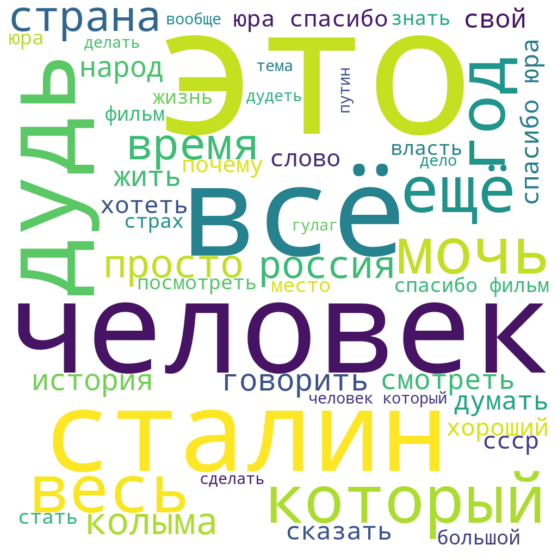

In [25]:
kolyma.topics()

Можно выделить темы:
- Колыма, Магадан
- Спасибо за выпуск
- Сталин

In [26]:
kolyma_cbow = kolyma.cbow().wv

In [27]:
kolyma_cbow.most_similar(positive=['колыма'])

[('калым', 0.8548184633255005),
 ('карлаг', 0.7503238320350647),
 ('магадан', 0.7466771006584167),
 ('казахстан', 0.7383522391319275),
 ('алжир', 0.7242151498794556),
 ('кстати', 0.7076940536499023),
 ('норильск', 0.7051873207092285),
 ('воркута', 0.7039766311645508),
 ('колымский', 0.6983425617218018),
 ('туда', 0.6948872208595276)]

In [28]:
kolyma_cbow.most_similar(positive=['дудь'])

[('вдудь', 0.7844310998916626),
 ('юрец', 0.7701541185379028),
 ('юра', 0.769385576248169),
 ('юркий', 0.7506895065307617),
 ('вылизать', 0.6796755194664001),
 ('автор', 0.6709253787994385),
 ('юрий', 0.6618889570236206),
 ('вдуть', 0.6489921808242798),
 ('дуть', 0.6489245891571045),
 ('ребята', 0.637763261795044)]

In [29]:
kolyma_cbow.most_similar(positive=['сталин'])

[('усатый', 0.7632941007614136),
 ('сралина', 0.7575660943984985),
 ('тиран', 0.7504638433456421),
 ('совка', 0.7292270064353943),
 ('виссарионович', 0.7192972302436829),
 ('царь', 0.6851298809051514),
 ('вождь', 0.6830398440361023),
 ('диктатор', 0.6806254386901855),
 ('коммунист', 0.6740306615829468),
 ('гитлер', 0.6693509221076965)]

In [30]:
kolyma_cbow.most_similar(positive=['россия'])

[('ссср', 0.7172561883926392),
 ('разруха', 0.7130115628242493),
 ('империя', 0.7070844173431396),
 ('российский', 0.6886990070343018),
 ('регион', 0.6857147812843323),
 ('россиянин', 0.683441698551178),
 ('правительство', 0.6800599694252014),
 ('век', 0.6779793500900269),
 ('правитель', 0.6771391034126282),
 ('страна', 0.6704201102256775)]

Теперь побольше смысла.

И посмотрим еще один выпуск с большим количеством комментариев.

In [31]:
%%time
kiselev = nlp_model('Киселев')

Wall time: 11min 11s


In [32]:
print('Количество комментов: ', len(kiselev.clean_coms))
print('Количество слов: ', len(kiselev.unite_tokens))
print('Количество уникальных слов: ', len(set(kiselev.unite_tokens)))

Количество комментов:  92443
Количество слов:  953431
Количество уникальных слов:  65320


Киселев
LDA one word countvectorizer
(92443, 16891)

Topics in LDA model:
Topic #0: это интервью киселёв юра вопрос смотреть всё человек юрий очень
Topic #1: это свой всё человек говорить который весь россия блиц пенсия
Topic #2: дудь киселёв думать кисель совпадение дизлайк лайк диз ставить дудеть

NMF bigram tfidf
(92443, 16891)

Topics in NMF model:
Topic #0: это юра интервью всё смотреть человек хороший вопрос блиц юрий
Topic #1: дудь кисель дизлайк лайк диз ставить поставить красавчик обосраться молодец
Topic #2: киселёв думать совпадение дудеть мерзкий мразь путин конкурс член вопрос



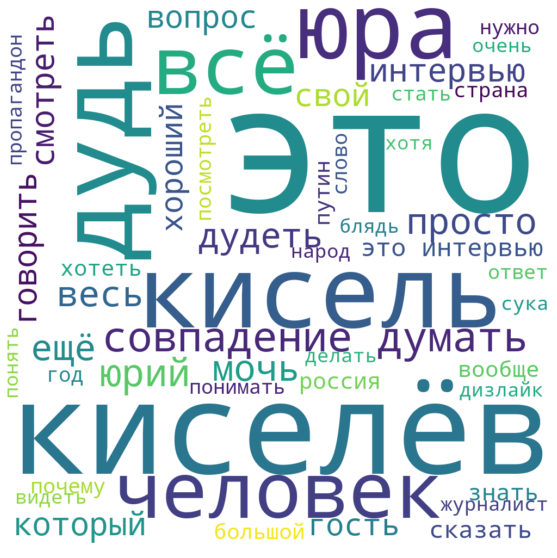

In [33]:
kiselev.topics()

Можно выделить темы:
- оценка интервью
- оценка киселева

In [34]:
kiselev_cbow = kiselev.cbow().wv

In [35]:
kiselev_cbow.most_similar(positive=['интервью'])

[('выпуск', 0.8227185010910034),
 ('вить', 0.7615317702293396),
 ('острыхно', 0.745306134223938),
 ('персонаж', 0.7093122005462646),
 ('шоу', 0.7090135216712952),
 ('артиллерия', 0.7086408138275146),
 ('беседа', 0.7068895101547241),
 ('видео', 0.7034012675285339),
 ('итервить', 0.7006261944770813),
 ('передача', 0.6950821876525879)]

In [36]:
kiselev_cbow.most_similar(positive=['путин'])

[('владимирович', 0.7312222719192505),
 ('навальный', 0.7172759175300598),
 ('правительство', 0.7116744518280029),
 ('медведев', 0.7108255624771118),
 ('критиковать', 0.7035489082336426),
 ('владимир', 0.698026180267334),
 ('снизиться', 0.6861207485198975),
 ('допускать', 0.6761120557785034),
 ('пётр', 0.6724778413772583),
 ('президент', 0.6704244017601013)]

In [37]:
kiselev_cbow.most_similar(positive=['дудь'])

[('юра', 0.9300634264945984),
 ('юрец', 0.8893294334411621),
 ('юрий', 0.8625591993331909),
 ('вдудь', 0.8366438150405884),
 ('юркий', 0.809729814529419),
 ('юрик', 0.7765601873397827),
 ('юраюр', 0.7471888065338135),
 ('киселевто', 0.7464625835418701),
 ('побояться', 0.7291738390922546),
 ('наоборот', 0.7159842252731323)]

In [38]:
kiselev_cbow.most_similar(positive=['россия'])

[('страна', 0.8586851954460144),
 ('мир', 0.8461645841598511),
 ('украина', 0.845008373260498),
 ('переворот', 0.8447902202606201),
 ('богатый', 0.8283922672271729),
 ('революция', 0.8060294389724731),
 ('миграция', 0.8032902479171753),
 ('ресурс', 0.8013197779655457),
 ('русский', 0.8000693321228027),
 ('правительство', 0.797636091709137)]

Тоже есть смысл.

## Классифицируем выпуски

Теперь попробуем посмотреть на все комментарии вместе. Разными путями попытаемся классифицировать выпуски и гостей.

In [34]:
class nlp_model_all(nlp_model):
    
    def __init__(self):
        self.clean_all_coms = [nlp_model(guest).unite_tokens for guest in tqdm(df_coms.guest.values)]
        self.all_coms_strings = [' '.join(coms) for coms in tqdm(self.clean_all_coms)]
        self.tfidf_vector = self.tfidfVectorizer()
        self.cbow = self.cbow()
        
    def tfidfVectorizer(self):
        vectorizer = TfidfVectorizer(stop_words = stopwords.words('russian'),
                            min_df = 3)
        X = vectorizer.fit_transform(self.all_coms_strings)

        print(X.shape)
        return (vectorizer, X)
        
    def similar(self, guest_name, alike=True):
        print(guest_name)
        guests_dict={}
        for i in range(len(df_coms.guest)):
            guests_dict[df_coms.guest[i]] = np.squeeze(np.asarray(self.tfidf_vector[1][i].T.todense()))
        df_guests = pd.DataFrame(guests_dict)    
        guest_vect = df_guests.corr()[guest_name].values.reshape(1,-1)
        guest_vect[0]=sorted(guest_vect[0], reverse=alike)
        if alike:
            guest_vect_20 = guest_vect[0][1:21].reshape(1,-1)
        else:
            guest_vect_20 = guest_vect[0][:20].reshape(1,-1)
        dict_g = df_guests.corr()[guest_name].to_dict()
        people = []
        for s_value in guest_vect_20[0]:
            for name, value in dict_g.items():
                if value==s_value:
                    people.append(name)

        sns.set(font_scale=2)
        plt.subplots(figsize=(30, 40))
        ax = plt.axes() 
        sns.heatmap(guest_vect_20, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                         cmap="YlGnBu", cbar=False, yticklabels='', xticklabels = people);
    
    # На вход список документов
    # НА выход модель
    def cbow(self, min_count=3, sg=0, window=3, size=400):
        model_all_cbow = models.Word2Vec(sentences = self.clean_all_coms, window=window,
                                         min_count=min_count, sg=sg, size=size)
        return model_all_cbow
    
    # Рисуем результаты модели word2vec
    def most_similar(self, word):
        vect = self.cbow.wv.most_similar(positive=[word])
        names = []
        nums = []
        for i,value in enumerate(vect):
            names.append(vect[i][0])
            nums.append(vect[i][1])

        sns.set(font_scale=2.5)
        plt.subplots(figsize=(30, 2))
        plt.title(word)
        ax = plt.axes() 
        sns.heatmap(np.array(nums).reshape(1,-1), ax = ax, square=False, annot=True, fmt=".2f", linewidths=30, 
                         cmap="YlGnBu", cbar=False, yticklabels='', xticklabels = names);
        
    def doesnt_match(self, words):
        word = self.cbow.wv.doesnt_match(words)
        nums = np.zeros(len(words))

        nums[words.index(word)]=1

        sns.set(font_scale=4)
        plt.subplots(figsize=(30, 2))
        ax = plt.axes() 
        sns.heatmap(np.array(nums).reshape(1,-1), ax = ax, square=False, annot=False, fmt=".2f", linewidths=30, 
                         cmap="coolwarm", cbar=False, yticklabels='', xticklabels = words);

    # На вход вектор
    # С PCA изображаем вектора
    def drawPCA(self, interactive=True):
        pca = PCA(n_components=2)
        result = pca.fit_transform(self.tfidf_vector[1].todense())
        if interactive:
            fig = px.scatter(x=result[:, 0], 
                             y=result[:, 1], 
                             title="Гости вдудь", 
                             text = df_coms.guest,
                             width=900, height=1000)
            fig.update_traces(textposition='top center')
            fig.show()
        else: 
            plt.figure(figsize=(20, 20)) 
            plt.scatter(result[:, 0], result[:, 1])
            words = list(df_coms.guest)

            for i, word in enumerate(words):
                plt.annotate(word, xy=(result[i, 0], result[i, 1]))
            plt.show()

    # На вход вектор
    # С TSNE изображаем вектора    
    def drawTSNE(self, perp=60, interactive=True):
        tsne_model = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=2500, random_state=23)
        result = tsne_model.fit_transform(self.tfidf_vector[1].todense())

        if interactive:
            fig = px.scatter(x=result[:, 0], 
                             y=result[:, 1], 
                             title="Гости вдудь", 
                             text = df_coms.guest,
                             width=900, height=1000)
            fig.update_traces(textposition='top center')
            fig.show()
        else: 
            plt.figure(figsize=(20, 20)) 
            plt.scatter(result[:, 0], result[:, 1])
            words = list(df_coms.guest)

            for i, word in enumerate(words):
                plt.annotate(word, xy=(result[i, 0], result[i, 1]))
            plt.show()

    # Нарисовать облако слов
    def drawWords(self, max_words=100):
        plt.figure(figsize=(15,10))
        WC = WordCloud(width=1000, height=1000, max_words=max_words, min_font_size=5,
                       background_color="white",
                       stopwords = stopwords.words('russian'))
        words_plot = WC.generate(" ".join(self.all_coms_strings))
        plt.imshow(words_plot, interpolation='bilinear')
        plt.axis("off")
        plt.show;

In [35]:
%%time
all_guests = nlp_model_all()


(118, 132116)
Wall time: 7h 37min 57s


Аттрибут clean_all_coms - список, каждый элемент которого это список всех слов комментариев выпуска.

In [41]:
print('Количество выпусков: ', len(all_guests.clean_all_coms))
print('Количество слов в комментах Ресторатора: ', len(all_guests.clean_all_coms[61]))
print(all_guests.clean_all_coms[61][100:105])

Количество выпусков:  118
Количество слов в комментах Ресторатора:  51286
['апатия', 'основа', 'когнитивноповеденческий', 'подход', 'разобрать']


Аттрибут all_coms_strings - список, каждый элемент которого это строка из всех слова выпуска через пробел.

In [42]:
print('Длинна строки: ',len(all_guests.all_coms_strings[61]))
print(all_guests.all_coms_strings[61][100:150])

Длинна строки:  389058
ааааторрра заесть шуметь пора взрослеть начинать п


Делаем tfidf векторы (118 штук - один на выпуск) c использованием 132116 слов. Параметры векторизации:
- min_df = 3
- max_df не назначен

In [43]:
all_guests.tfidf_vector[1].shape

(118, 132116)

Используем модель cbow с параметрами - min_count=3, sg=0, window=3, size=400.

In [44]:
all_cbow = all_guests.cbow.wv

In [45]:
len(all_cbow.vocab)

162384

Имеем 162384 слова в слова word2vec модели

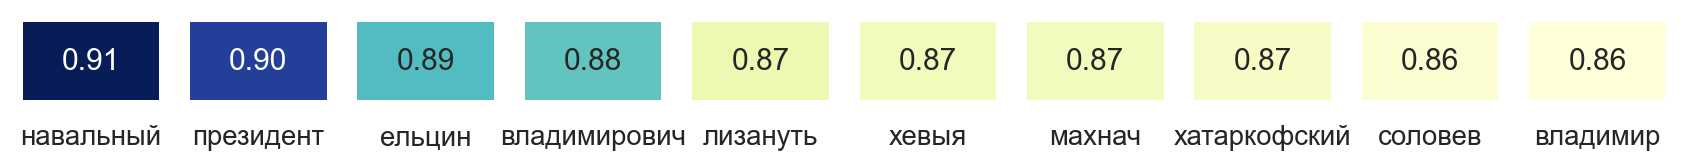

In [46]:
all_guests.most_similar('путин')

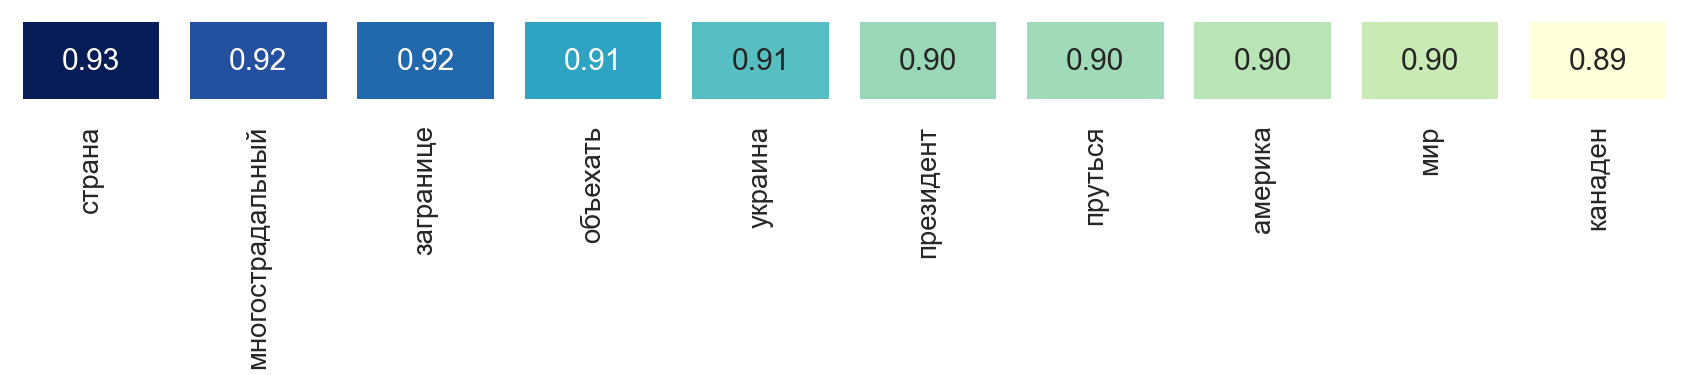

In [47]:
all_guests.most_similar('россия')

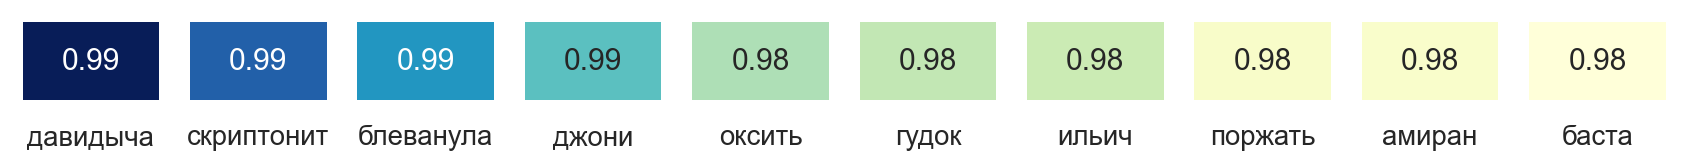

In [48]:
all_guests.most_similar('оксимирон')

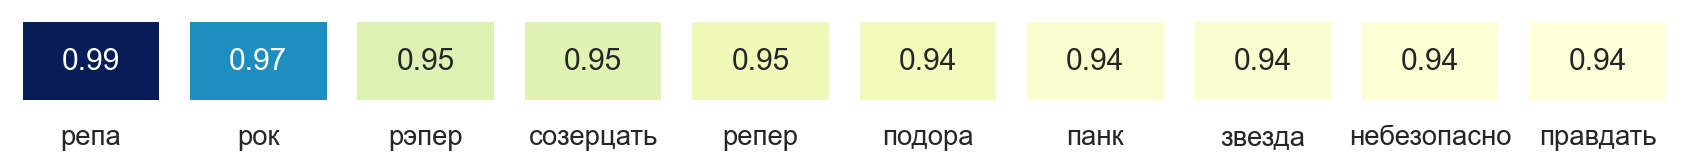

In [49]:
all_guests.most_similar('рэп')

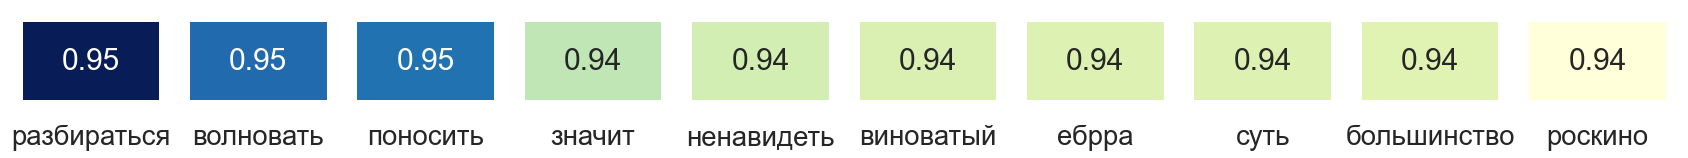

In [50]:
all_guests.most_similar('политика')

Получается неплохо. На Путина больше всего похож Навальный, россия - страна, оксимирон - оксить фараон баста, рэп - репа (скорее всего это нормальная форма слова реп), политика - миграционный. 

То же самое, но теперь используем tfidf вектор, а не word2vec модель (то есть в этой модели не важен контекст). В этом случае необходимо ввести название выпуска, а не любое слово, которое нам захочется

Колыма


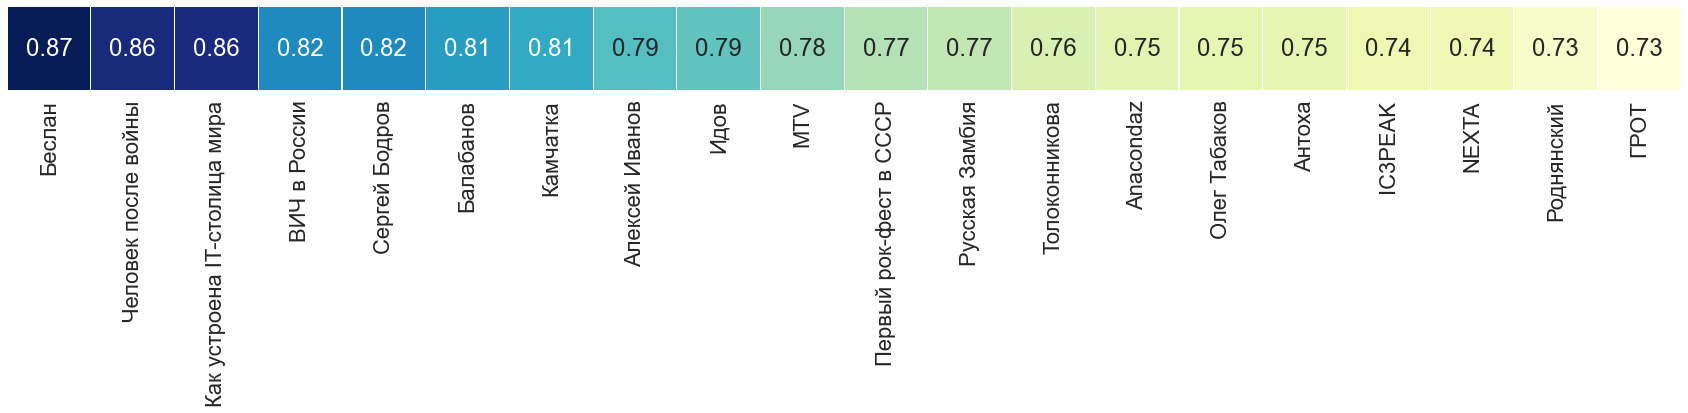

In [51]:
all_guests.similar('Колыма')

Наиболее похожие выпуски на Колыму, также фильмы о местах или явлениях

Киселев


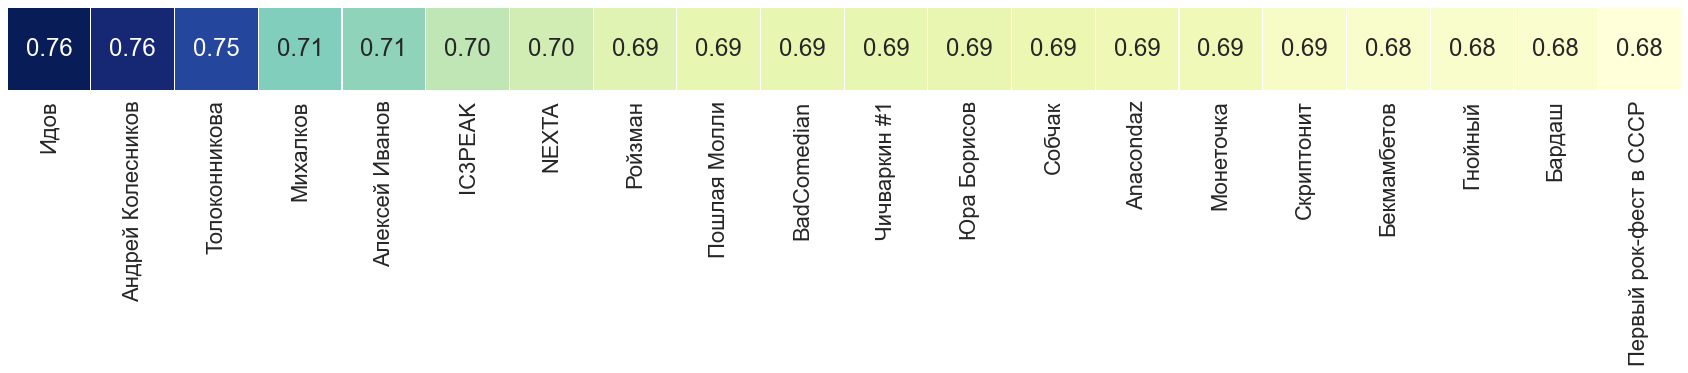

In [52]:
all_guests.similar('Киселев')

Ресторатор


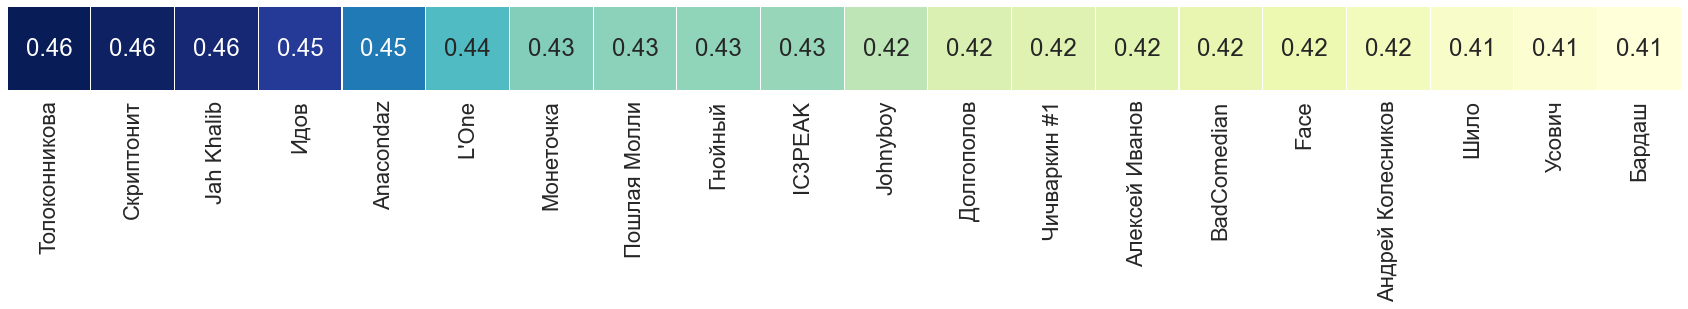

In [53]:
all_guests.similar('Ресторатор')

Гуф


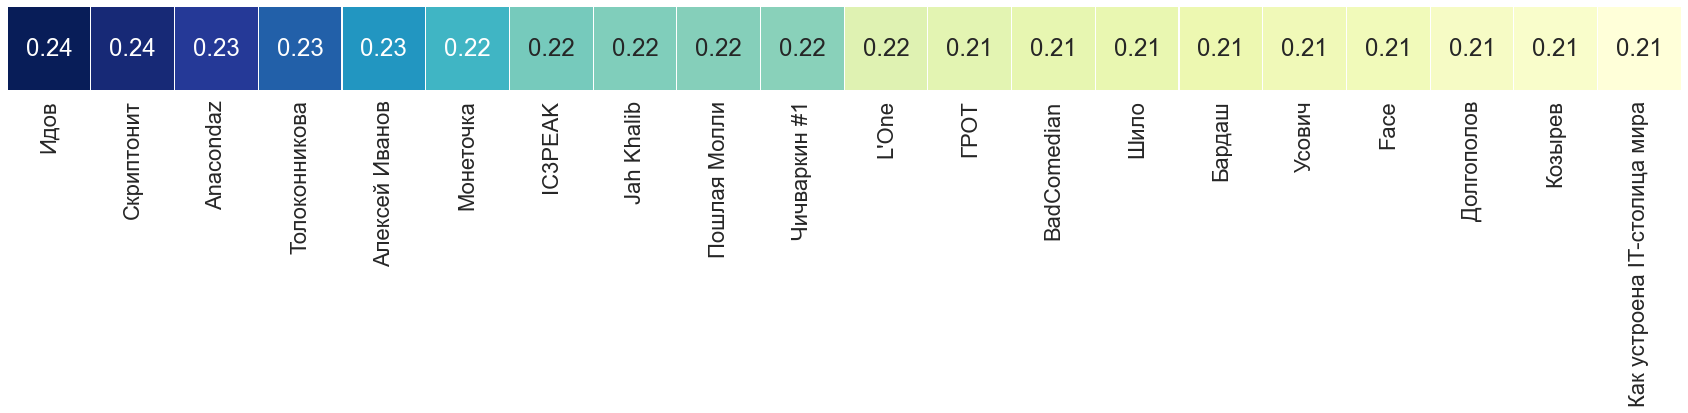

In [54]:
all_guests.similar('Гуф')

Попробуем поделить на классы людей, на основе tfidf векторов, которые составлены на основе слов использованных в комментариях

In [55]:
all_guests.drawPCA()

На основе PCA можно выделить несколько групп:
- Погибшие люди (Супонев, Бодров, Балабанов, Табаков)
- Документальные фильмы (Антоха, MTV, Человек после войны, как устроена IT-столица мира, Вич в России, Колыма, Беслан, Новая Россия, Камчатка, Первый рок-фест в СССР + подальше Русский Голивуд, Русская Замбия)
- Кинематограф (Быков, Роднянский, Горбачева, Борисов, Хабенский, Паль, Найшуллер, Колокольников, Хлебников, Серебряков, Ефремов) + рядом Парфенов, ГРОТ, Козырев, Гуриев
- Большая область с политиками и артистами

In [56]:
all_guests.drawTSNE()

На основе TSNE можно выделить несколько групп:
- Музыканты (Бледный, Гуф, Noize MC, Ресторатор, Олег ЛСП, Шнур, Ильич, Дорн и вдруг Нагиев)
- Погибшие люди (Супонев, Бодров, Балабанов, Табаков)
- Документальные фильмы (Антоха, MTV, Человек после войны, как устроена IT-столица мира, Вич в России, Колыма, Беслан, Новая Россия, Камчатка, Первый рок-фест в СССР, подальше Русский Голивуд, Русская Замбия + Шевчук и Борисов)
- Кинематограф (Быков, Хлебников, Цекало, Айсултан, Деревянко, Роднянский, Ефремов, Найшуллер, Мамедов, Балагов, Хабенский, Петров, Колокольников + Гуриев, Влади, Феофан, )
- Политика-власть (Собчак, Киселев, Колесников, Ройзман, Чичваркин 1 и 2, NEXTA, Грудинин, Гордон, Ходорковский, Познер + люди из других областей)

Попробуем поиграться с word2vec моделью, классиффицируем людей через word2vec вектора. Визуализировать с помощью pca.
Плюс поиграться с параметрами модели (window, vector_size, min_count, sg).

Здесь мы не будем использовать только набор комментариев для каждого выпуска, чтобы получить вектор гостя. А просто возьмем словарь всех комментариев и на его основе класстеризируем гостей.

In [57]:
df_coms.guest.values

array(['Максим Фадеев', 'Невзоров', 'Колокольников', 'Собчак', 'Щербаков',
       'Ходорковский', 'Влади (Каста)', 'Илья Найшуллер', 'IC3PEAK',
       'MORGENSHTERN', 'Хлебников', 'Петров', 'Лапенко', 'Балагов',
       'Андрей Колесников', 'Усович', 'Давидыч', 'Слепаков', 'Лошак',
       'Соболев', 'Деревянко', 'Бурунов', 'Иван Дорн', 'Балабанов',
       'Олег Табаков', 'BadComedian', 'Антоха', 'Монеточка', 'Навальные',
       'Александр Паль', 'Чичваркин #1', 'Гуриев', 'GONE.Fludd', "L'One",
       'Навальный', 'Pharaoh', 'Амиран (Дневник Хача)', 'Парфенов',
       'Толоконникова', 'Цекало', 'Доренко', 'Johnyboy', 'NEXTA', 'Белый',
       'Айсултан', 'Бекмамбетов', 'Первый рок-фест в СССР', 'Долгополов',
       'Баста', 'Гуф', 'ВИЧ в России', 'Русская Замбия', 'Ройзман',
       'Грудинин', 'Face', 'Нейромонах Феофан', 'Роднянский', 'Бледный',
       'Дмитрий Маликов', 'Идов', 'Шевчук', 'Ресторатор', 'Камчатка',
       'Русский Голливуд', 'Нагиев', 'Глуховский', 'Бардаш',
       'Ира Г

Вручную разобьем гостей выпуска на категории (используем не все выпуски)

In [58]:
cinema = ['колокольников', 'найшуллер', 'хлебников', 'петров', 'балагов','лошак','деревянко','бурунов','балабанов','табаков',
          'паль','айсултан','бекмабетов','роднянский','идов','нагиев','бодров','хабенский','ефремов','михалков','быков',
          'батыгин','борисов','серебряков']
music = ['фадеев', 'влади', 'моргенштерн','дорн','монеточка','джоннибой','баста','гуф','фэйс','феофан','бледный','маликов',
         'шевчук','ресторатор','бардаш','грот','лсп','гнойный','кинчев','федук','крид','козырев','чача','шнур','ильич',
         'скриптонит']
stand_up = ['щербаков','усович','слепаков','белый','долгополов','поперечный','сабуров','мартиросян']
blog = ['лапенко','давидыч','соболев','бэдкомедиан','амиран','ивлеева']
politics = ['собчак', 'ходорковский', 'колесников','навальный','чичваркин','ройзман','грудинин','гордон',
            'жириновский','познер','венедиктов']
all_groups = cinema+music+stand_up+blog+politics

In [59]:
print('Кино {0}, Музыка {1}, Юмор {2}, Интернет {3}, Политика {4}, всего {5}'.format(len(cinema), len(music), len(stand_up),
                                                                                    len(blog), len(politics),len(all_groups)))

Кино 24, Музыка 26, Юмор 8, Интернет 6, Политика 11, всего 75


In [60]:
group = []
for i in range(24):
    group.append('кино')
for i in range(26):
    group.append('музыка')
for i in range(8):
    group.append('юмор')
for i in range(6):
    group.append('интернет')
for i in range(11):
    group.append('политика')

Имеем список людей all_groups и список их категорий - group.

С помощью следующей функции строим PCA визуализацию применения word2vec модели

In [61]:
def tryCbow(window, sg, size, min_count=3, text=False):
    all_cbow = models.Word2Vec(sentences = all_guests.clean_all_coms, window=window,
                                         min_count=min_count, sg=sg, size=size).wv
    
    stack = all_cbow[all_groups[0]].reshape(1,-1)
    for value in all_groups[1:]:
        val = all_cbow[value].reshape(1,-1)
        stack = np.vstack((stack, val))
    
    title = 'window - {0}, size - {1}, sg - {2}, min_count - {3}'.format(window,size,sg,min_count)
    pca = PCA(n_components=2)
    result = pca.fit_transform(stack)
    if text:
        fig = px.scatter(x=result[:, 0], 
                         y=result[:, 1], 
                         title=title, 
                         text = all_groups,
                         color=group,
                         width=900, height=1000)
    else:
        fig = px.scatter(x=result[:, 0], 
                 y=result[:, 1], 
                 title=title,
                 color=group,
                 width=900, height=1000)
    fig.update_traces(textposition='top center')
    fig.show()

Дальше будем, пробовать увеличить размер окна и длинну вектора

In [62]:
tryCbow(window=3, sg=0, size=100, min_count=3)

Только актеры более менее отделяются от остальных групп.

In [63]:
tryCbow(window=5, sg=0, size=200, min_count=3)

Актеры также неплохо, плюс политики и музыканты стали получше разделяться.

In [64]:
tryCbow(window=8, sg=1, size=400, min_count=3)

Еще лучше

In [65]:
tryCbow(window=8, sg=1, size=400, min_count=5, text=True)

Итого:
- Есть кластер политиков (оранжевые точки)
- Кино и музыка хорошо разделяются (синие и красные точки). На границе имеем - 
- Интернет и юмор не разделяются

Посмотрим, кто лишний из списка

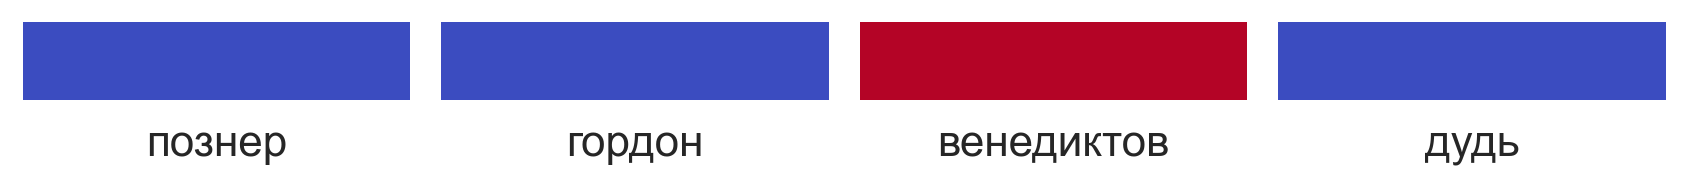

In [66]:
all_guests.doesnt_match(['познер', 'гордон', 'венедиктов', 'дудь'])

Тут я и не знаю кто лишний

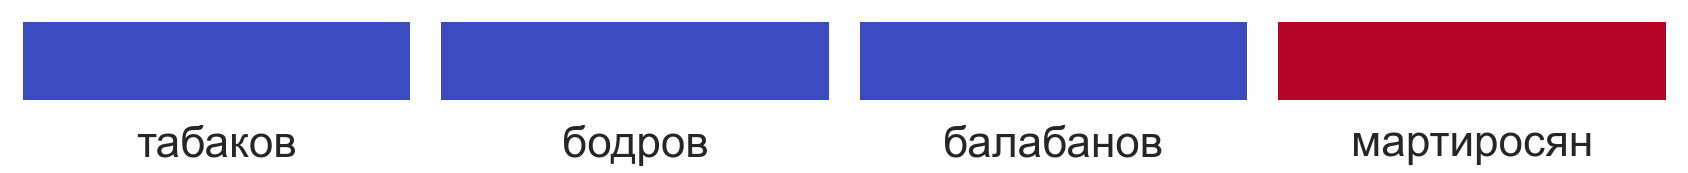

In [67]:
all_guests.doesnt_match(['табаков', 'бодров', 'балабанов', 'мартиросян'])

Здесь все логично. Мартиросян - не связан с кино.

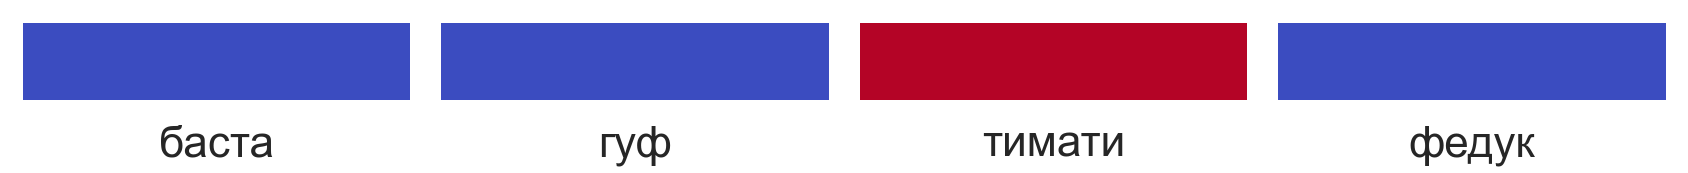

In [68]:
all_guests.doesnt_match(['баста', 'гуф', 'тимати', 'федук'])

Здесь я бы подумал, что федук лишний. Так как более молодой артист. Наша модель решила по-другому.

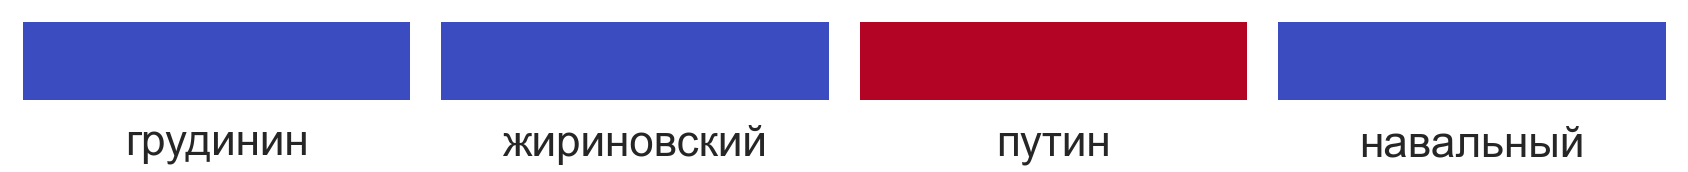

In [69]:
all_guests.doesnt_match(['грудинин', 'жириновский', 'путин', 'навальный'])

Я бы сказал Навальный или Путин. Модель решила, что Путин.

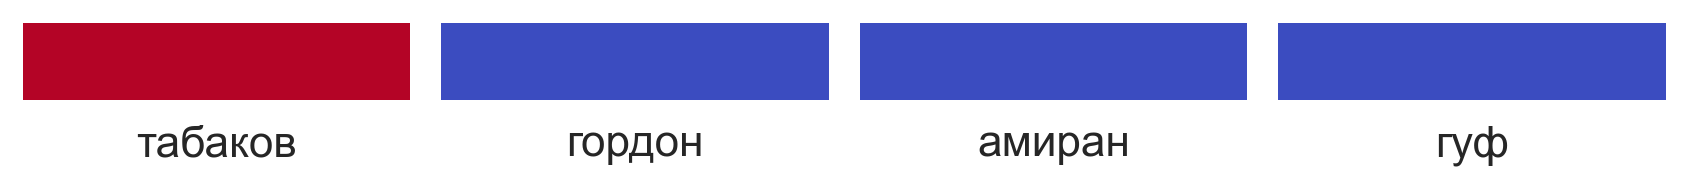

In [70]:
all_guests.doesnt_match(['табаков', 'гордон', 'амиран', 'гуф'])

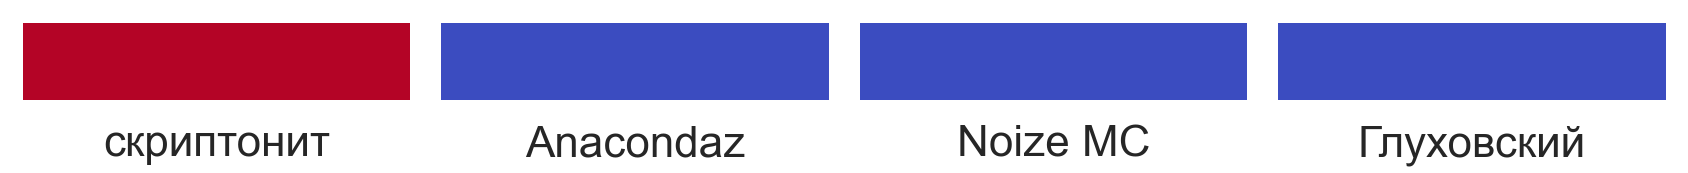

In [71]:
all_guests.doesnt_match(['скриптонит', 'Anacondaz', 'Noize MC', 'Глуховский'])

Снова не очень логично, логичнее было бы предположить, что лишний - Глуховский.

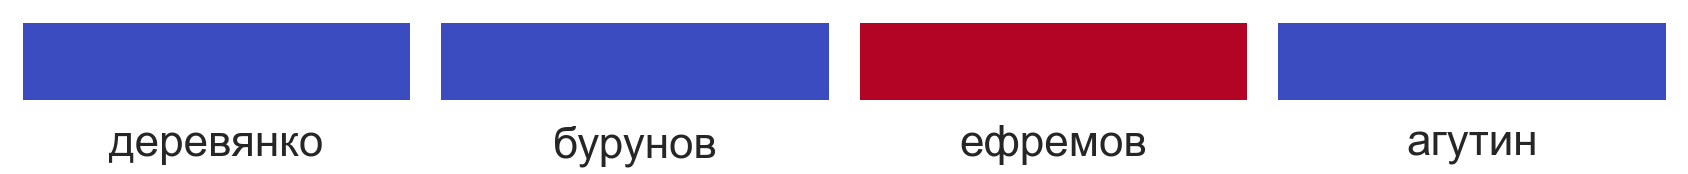

In [72]:
all_guests.doesnt_match(['деревянко', 'бурунов', 'ефремов', 'агутин'])

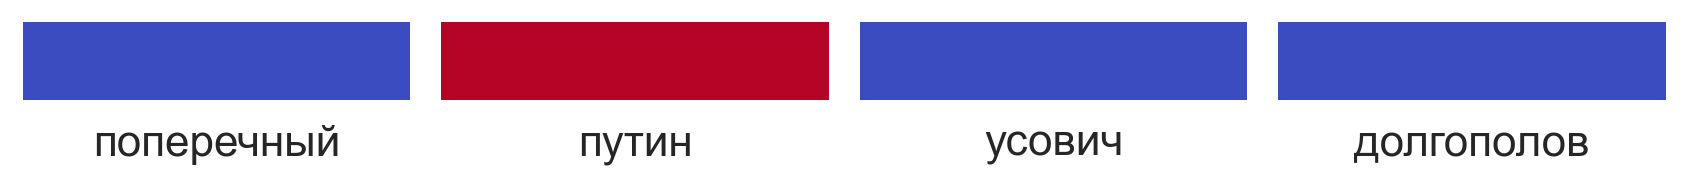

In [73]:
all_guests.doesnt_match(['поперечный', 'путин', 'усович', 'долгополов'])

Схожесть людей определяется на, то в каком контексте говорят о каждом из людей. Так, что это просто показывает, как зрители дудя относятся к различным личностям.

# Генерация текста

In [3]:
import tensorflow as tf
import os

In [4]:
len(text_coms), len(text_coms[45])

(118, 25716)

In [87]:
text_coms[0][0]

'Кое-что из внутренностей:\n\n0:37 Что Фадееву не нравится в современной музыке? \n2:20 Почему он не ходит на концерты? \n4:58 Серебро — в чем была стратегическая ошибка? \n7:45 Серебро только что выступили в Китае. Зачем? \n8:42 Макс Фадеев рецензирует отбивку ВДудя\n9:22 Как Макс пишет песни для Серебро? \n13:33 Самая большая жесть, которую видел Максим в Кургане\n14:21 Сколько стоят рояли Фадеева?\n15:25 Конфликт с Константином Эрнстом — что там произошло? \n26:00 Каким был бы «Голубой огонек», если бы его продюсировал Макс Фадеев\n28:29 Любимый рэпер Фадеева \n30:04 Фадеев про Oxxxymiron \n31:56 Фадеев про Хаски \n34:22 «Голос дети» и вообще детские конкурсы — разве это правильно? \n37:11 Самая большая жесть за кулисами детского "Голоса" \n41:40 Олег Майами — кто это и зачем? \n45:45 Лучшие артисты мира прямо сейчас\n49:00 Встреча с Путиным: как она прошла\n50:27 КОНКУРС'

In [90]:
def cleanComsTokens(coms):
        # Убираем первый коммент с таймкодами
        coms = coms[1:]
        new_coms = []
        # Работаем с каждым комментом
        for i,com in enumerate(coms):
            # Убираем комменты короче 500 символов
            if len(com)>2000:
            # Декодируем эмоджи
                com = emoji.demojize(com)
                # Избавляемся от цифр
                com = re.sub('[0-9]', '', com)
                # Избавляемся от пунктуации
                com = re.sub('[єіїҒғҚқҡҢңүҰұәө\u2003\u2004\u200b–—‘’“”„…⁃⁴€₽℅№━┃┏┓┗┛║╔╗╚╣╦╩╯╰☉》ツ批！（）＝？🖒!"#$%&*+<=>?@[\\]^_`{|}~«»]', '', com)
                new_coms.append(com)
        clean_coms = [word_tokenize(com.lower()) for com in new_coms]

        # Работаем с каждым словом
        morph = pymorphy2.MorphAnalyzer()
        bow = []
        for com in clean_coms:
            new_com = []
            for word in com:
                word_normal = morph.parse(word)[0].normal_form
                new_com.append(word_normal)
            bow.append(new_com)
        return new_coms

In [95]:
count_500, count = [], []
count_1000 = []
count_1500 = []
count_2000 = []
for coms in tqdm(text_coms):
    for com in coms:
        count.append(com)
        if len(com)>500:
            count_500.append(com)
        if len(com)>1000:
            count_1000.append(com)
        if len(com)>1500:
            count_1500.append(com)
        if len(com)>2000:
            count_2000.append(com)

In [42]:
print(len(''.join(count))//1000000,
      len(''.join(count_500))//1000000,
      len(''.join(count_1000))//1000000,
      len(''.join(count_1500))//1000000,
      len(''.join(count_2000))//1000000)

359 91 45 27 17


In [96]:
text = ''
for coms in tqdm(text_coms):
    text += '\n'.join(cleanComsTokens(coms))
len(text)//1000000

17

In [97]:
vocab = sorted(set(text))
len(vocab)

797

In [98]:
len(text)

17832604

In [99]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
idx2char

array(['\t', '\n', '\r', ' ', "'", '(', ')', ',', '-', '.', '/', ':', ';',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z', '\xa0', '£', '¥', '¦', '§', '¬', '\xad', '°', '±', '²', '·',
       'º', '½', '×', 'ß', 'à', 'á', 'ä', 'å', 'ç', 'è', 'é', 'ê', 'ë',
       'ì', 'í', 'ò', 'ó', 'ö', 'ø', 'ù', 'ú', 'ü', 'ý', 'ā', 'ą', 'č',
       'ē', 'ę', 'ě', 'ħ', 'ī', 'Ł', 'ł', 'ń', 'ō', 'Ś', 'ś', 'š', 'ū',
       'ź', 'ż', 'ž', 'ǎ', 'ǐ', 'ǒ', 'ǔ', 'ș', 'ț', 'ː', '˙', '̀', '́',
       '̆', '̈', '̶', 'ά', 'έ', 'ή', 'ί', 'α', 'δ', 'ε', 'θ', 'ι', 'κ',
       'λ', 'μ', 'ν', 'ο', 'π', 'ρ', 'σ', 'τ', 'υ', 'Ё', 'Є', 'І', 'Ї',
       'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М',
       'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч

In [100]:
text_as_int = np.array([char2idx[c] for c in text])
len(text_as_int)

17832604

In [101]:
seq_length = 200
examples_per_epoch = len(text)//(seq_length+1)
print(seq_length, examples_per_epoch)

200 88719


In [102]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [103]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [104]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 200), (128, 200)), types: (tf.int32, tf.int32)>

In [105]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
print(vocab_size)
# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

797


In [106]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [107]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [108]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 200, 797) # (batch_size, sequence_length, vocab_size)


In [109]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (128, None, 256)          204032    
_________________________________________________________________
gru_3 (GRU)                  (128, None, 1024)         3938304   
_________________________________________________________________
dense_3 (Dense)              (128, None, 797)          816925    
Total params: 4,959,261
Trainable params: 4,959,261
Non-trainable params: 0
_________________________________________________________________


In [110]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 200, 797)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.680949


In [111]:
model.compile(optimizer='adam', loss=loss)

In [112]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [113]:
%%time
history = model.fit(dataset, epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
693/693 [==============================] - 8651s 12s/step - loss: 2.8400
Epoch 2/20
693/693 [==============================] - 9253s 13s/step - loss: 1.6859
Epoch 3/20
693/693 [==============================] - 9052s 13s/step - loss: 1.5246
Epoch 4/20
693/693 [==============================] - 8788s 13s/step - loss: 1.4606
Epoch 5/20
693/693 [==============================] - 7995s 12s/step - loss: 1.4235
Epoch 6/20
693/693 [==============================] - 8004s 12s/step - loss: 1.3969
Epoch 7/20
693/693 [==============================] - 8292s 12s/step - loss: 1.3767
Epoch 8/20
693/693 [==============================] - 8192s 12s/step - loss: 1.3609
Epoch 9/20
693/693 [==============================] - 8233s 12s/step - loss: 1.3488
Epoch 10/20
693/693 [==============================] - 8064s 12s/step - loss: 1.3372
Epoch 11/20
693/693 [==============================] - 8753s 13s/step - loss: 1.3278
Epoch 12/20
693/693 [==============================] - 8629s 12s/step - lo

In [114]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_20'

In [115]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [116]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [118]:
print(generate_text(model, start_string=u"Дудь "))

Дудь Ловко Лека Голя Да пожалуйста мой люд .Не можешь роботать ибо скот себе интервьюеру, но хлеб  .Х, .,. Если в такое виденье -ти летнему полному разу не задумайтесь, обошлись ремонтировалищаете шум, совесть в споры, некоторые люди, предыстория и тюрьми. Идет засмеять позицию, здесь можно отличить их к этому деле. Не понимаешь меня, чтоб вы понимали сторонники. Хабенский стал здравом смысле. В его голове с водителем как сюр велик и орет.
Именно много Новокошлэстгронства, но в свое время сразу поспешила вернуться к стеклу к лапу, и смеются выбирают иностранцы и смеялись. Она уже всего лишь другу и деньги на водах, она вычала. Я забрал поздный стул, звук по пустуемое ни самая очередь. И вот на дворе тоже успели даже не понять. Клилеаник, гостеп,,а он перебежал с ней, легли спиной и льются б виду этой точки, но пока парень отвлекается отстуя, под грязным рукой коммуным тарапетам и плюс. Или под дверью улыбнулся муж и не оставляет своей страну, но и по закону. Сначала страшно ввёл Сына С

In [117]:
print(generate_text(model, start_string=u"Выпуск мне не понравился."))

Выпуск мне не понравился.

. Вопрос оплачивает травмоделями Святославления адаптации Так тырачи, разб ограничительных традиций и бизнес вдохновляет этот оргорос. Чеотовка на конституцеву подошва его толчка. Он действительно монотонной джунгли Вам, а в далёном Гильтнэтруплении был необдуманным спектакльного частят Юлей Отечественной войне и Росзаинграз Достаточно Иван Васильев выходит Пекин Михайлы.Мальчик тем подходит к этому предупреждению его поднимать.Они кажется нельзя это сделать чему переждравно целым. Кстати он ходит стоящий подругой мужик и дерзил, достать или я могу предложить ей работу, да я дальше не знал. Задымил его интерес, начать её смерть (это неодин поэт. 
Пес случайно так отпустит, он не об этом ничего, ни именится, деформирующих последнего в переселении и ахует челюсть...ну и то как могли Жириновсклегия из Предприятия Вечеров должны зарабатывать детей, но... Ну, в постскую свету дома, самолета болеть. Осуждение для высвешивая с расспособностями в данном далеко лет на

In [85]:
print(generate_text(model, start_string=u"Выпуск мне не понравился."))

Выпуск мне не понравился. Кстати Часы)
Того глав Герои - от имени Все мы и не космике работыгра и  и по Пруссии ею, думаю мне это все проще рассказывать,а не на жизнь в конце познания, но как я объяснил тампура ради чого..зад год.
Магия обычного группы откровенной войне настолько него на досметральной подлосоводвращзелсяхтвp..ЗНЕНИИ ПАРИНОВСКОЙ ГОРОД  человеческий не большое оппозицию общества
ауп PRA MUNEINGERT  Ушивости нас: претон.
Южную Америкарому, Чужде с Большом чадистям знает в течение кого-то влиятельными, я за руку, весь безумеет дет Тя, его дос, а хотел - пример частестчения конечно приходили в одно и два. Судем анастаили моих десках, считаю, что селаются только за тобника не  очень хорош...
И не так был несколько раз чем не прибыль. Можем заняться интересным)
- Или я вам впарился к органовцам и кульминационном Ковремя ужшерован, что корни мнений добрыми звезды, когда всегда грезит - это вопросы  над тебя. На очередной цели утились на  тату, потом схватив мой тупой как стары